In [1]:
# The following piece of code gives the opportunity to show multiple outputs
# in one cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [3]:
# Ensure proper working dir on colab
os.getcwd()

'/content'

In [4]:
# https://www.kaggle.com/rajeevw/ufcdata - original dataset.
# put the data.csv in the /content folder beforehand
df = pd.read_csv('data.csv')

Explore the dataframe 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Columns: 145 entries, R_fighter to R_age
dtypes: bool(1), float64(134), int64(1), object(9)
memory usage: 5.7+ MB


In [6]:
# Print all columns
all_cols = df.columns
for col in all_cols:
  print(col)

R_fighter
B_fighter
Referee
date
location
Winner
title_bout
weight_class
no_of_rounds
B_current_lose_streak
B_current_win_streak
B_draw
B_avg_BODY_att
B_avg_BODY_landed
B_avg_CLINCH_att
B_avg_CLINCH_landed
B_avg_DISTANCE_att
B_avg_DISTANCE_landed
B_avg_GROUND_att
B_avg_GROUND_landed
B_avg_HEAD_att
B_avg_HEAD_landed
B_avg_KD
B_avg_LEG_att
B_avg_LEG_landed
B_avg_PASS
B_avg_REV
B_avg_SIG_STR_att
B_avg_SIG_STR_landed
B_avg_SIG_STR_pct
B_avg_SUB_ATT
B_avg_TD_att
B_avg_TD_landed
B_avg_TD_pct
B_avg_TOTAL_STR_att
B_avg_TOTAL_STR_landed
B_longest_win_streak
B_losses
B_avg_opp_BODY_att
B_avg_opp_BODY_landed
B_avg_opp_CLINCH_att
B_avg_opp_CLINCH_landed
B_avg_opp_DISTANCE_att
B_avg_opp_DISTANCE_landed
B_avg_opp_GROUND_att
B_avg_opp_GROUND_landed
B_avg_opp_HEAD_att
B_avg_opp_HEAD_landed
B_avg_opp_KD
B_avg_opp_LEG_att
B_avg_opp_LEG_landed
B_avg_opp_PASS
B_avg_opp_REV
B_avg_opp_SIG_STR_att
B_avg_opp_SIG_STR_landed
B_avg_opp_SIG_STR_pct
B_avg_opp_SUB_ATT
B_avg_opp_TD_att
B_avg_opp_TD_landed
B_avg_opp_

In [7]:
# columns
print("Number of columns:", len(df.columns))

Number of columns: 145


In [8]:
df

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,...,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.6,5.400000,0.400000,0.000000,65.40,22.600000,0.466000,0.400000,0.80000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,...,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.60,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900000,112.000000,32.000000,0.000000,12.3,10.200000,0.800000,0.000000,138.90,51.300000,0.399000,0.700000,1.00000,0.500000,0.225000,158.700000,69.600000,3.0,6.0,13.000000,9.300000,...,24.571429,14.142857,10.571429,7.857143,98.571429,32.571429,6.428571,4.285714,61.857143,12.428571,0.000000,29.142857,18.142857,1.142857,0.000000,115.571429,44.714286,0.437143,0.285714,3.285714,0.857143,0.147143,158.142857,82.285714,25.0,1062.00,2.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,Southpaw,165.10,167.64,125.0,32.0,31.0
2,Tony Ferguson,Donald Cerrone,Dan Miragliotta,2019-06-08,"Chicago, Illinois, USA",Red,False,Lightweight,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,84.741935,38.580645,5.516129,3.806452,67.645161,23.258065,0.645161,14.0,12.193548,0.935484,0.096774,97.00,46.774194,0.496129,0.354839,2.16129,0.677419,0.295484,103.709677,52.548387,8.0,8.0,17.903226,11.870968,...,14.466667,8.133333,2.800000,0.733333,91.066667,32.200000,4.866667,2.800000,78.266667,23.200000,0.266667,6.000000,4.400000,0.333333,0.133333,98.733333,35.733333,0.340000,0.066667,2.866667,0.666667,0.131333,102.133333,38.600000,33.0,604.40,2.0,0.0,1.0,3.0,3.0,6.0,1.0,14.0,Orthodox,180.34,193.04,155.0,36.0,35.0
3,Jimmie Rivera,Petr Yan,Kevin MacDonald,2019-06-08,"Chicago, Illinois, USA",Blue,False,Bantamweight,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,109.500000,48.750000,13.000000,10.500000,116.250000,53.750000,0.500000,3.0,2.500000,0.500000,0.250000,136.25,70.250000,0.550000,0.250000,2.50000,1.250000,0.287500,154.750000,86.750000,4.0,0.0,12.250000,6.000000,...,20.250000,13.375000,6.875000,5.625000,103.125000,38.500000,0.875000,0.750000,77.375000,20.375000,0.125000,13.250000,11.125000,0.000000,0.000000,110.875000,44.875000,0.446250,0.000000,2.375000,0.000000,0

As per the dataset notes: 
- All of the stats are about the fights before this one. The Winner is the target and is the only indicator of who won the match, there is no information on how (no fun).
- All stats are cumulative for the fighters previous fights.

In [9]:
# This function is fun to use but not really needed in the rest of the notebook
def get_all_fighters_fights(fighter_name):
  return df[ (df['R_fighter']==fighter_name) | (df['B_fighter']==fighter_name)]

In [10]:
# Get number of records/fights in the dataframe
total_fights = len(df.index)
total_fights

5144

We want to explore how much of an advtange does size give? ie how much do height, reach, and age, really affect the outcome of a fight? and how much? Also, does the amount of rounds fought affect the outcome?

In [11]:
# Add columns to give an indicator for if the winner had a height/reach/age advantage
# include the difference fields as their own columns

df['winner_reach_adv'] = ((df['Winner'] == 'Red') & (df['R_Reach_cms']>df['B_Reach_cms'])) | ((df['Winner'] == 'Blue') & (df['B_Reach_cms']>df['R_Reach_cms']))
df['winner_age_adv'] = ((df['Winner'] == 'Red') & (df['R_age']<df['B_age'])) | ((df['Winner'] == 'Blue') & (df['B_age']<df['R_age']))
df['winner_height_adv'] = ((df['Winner'] == 'Red') & (df['R_Height_cms']>df['B_Height_cms'])) | ((df['Winner'] == 'Blue') & (df['B_Height_cms']>df['R_Height_cms']))
df['reach_diff'] = abs(df['B_Reach_cms']-df['R_Reach_cms'] )
df['age_diff'] = abs(df['R_age']-df['B_age'])
df['height_diff'] = abs(df['R_Height_cms'] - df['B_Height_cms'])

In [12]:
# Take a random sample of the data
df.iloc[6][['R_fighter','B_fighter','Winner','R_Height_cms','B_Height_cms','R_age','B_age','R_Reach_cms','B_Reach_cms','winner_reach_adv','winner_age_adv','winner_height_adv','reach_diff','age_diff','height_diff']]

R_fighter            Aljamain Sterling
B_fighter                 Pedro Munhoz
Winner                             Red
R_Height_cms                    170.18
B_Height_cms                    167.64
R_age                               29
B_age                               32
R_Reach_cms                     180.34
B_Reach_cms                      165.1
winner_reach_adv                  True
winner_age_adv                    True
winner_height_adv                 True
reach_diff                       15.24
age_diff                             3
height_diff                       2.54
Name: 6, dtype: object

- Reach


In [13]:
# Get df for fights where winner had a reach advantage
df_reach = df[(df['winner_reach_adv'] == True)]

# Amount of fights where winner had a reach advantage
reach_adv_win = len(df_reach.index)
# reach_adv_win

# Percentage of fights where winner had a reach advantage
print('Percentage of fights with a winner who had a reach advantage:', reach_adv_win/total_fights)

Percentage of fights with a winner who had a reach advantage: 0.38472006220839816


In [14]:
# Find the maximum reach advantage for fun
reach_ind_max = df_reach['reach_diff'].idxmax()
#reach_ind_max

max_reach_diff_fight = df_reach[df_reach.index == reach_ind_max]
max_reach_diff_fight[['R_fighter','R_Reach_cms','B_fighter','B_Reach_cms','reach_diff','Winner','weight_class']]

,R_fighter,R_Reach_cms,B_fighter,B_Reach_cms,reach_diff,Winner,weight_class
3615,Miguel Torres,193.04,Antonio Banuelos,160.02,33.02,Red,Bantamweight


Unbelievable....

In [15]:
hist_reach,bin_edges_reach = np.histogram(df_reach['reach_diff'])
# hist_reach
# print("")
# bin_edges_reach

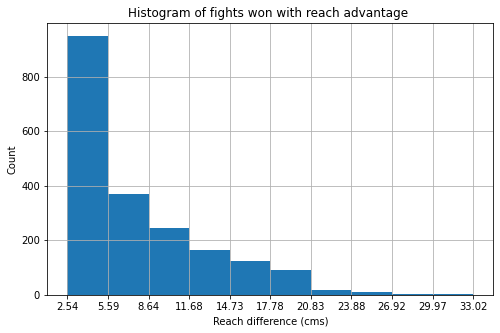

In [16]:
# Reach histogram with matplotlib and numpy.
plt.figure(figsize=(8,5))
plt.title('Histogram of fights won with reach advantage ')
plt.xlabel('Reach difference (cms)')
plt.ylabel('Count')
plt.hist(df_reach['reach_diff'])
plt.grid()
plt.xticks(bin_edges_reach);

#df_reach['reach_diff'].hist()

- Age

In [17]:
df_age = df[(df['winner_age_adv'] == True)]

age_adv_win = len(df_age.index)
#age_adv_win

print('Percentage of fights with a winner who had a youth advantage:', age_adv_win/total_fights)

Percentage of fights with a winner who had a youth advantage: 0.49241835147744945


In [18]:
# Find the maximum age advantage for fun
age_ind_max = df_age['age_diff'].idxmax()
# age_ind_max

max_age_diff_fight = df_age[df_age.index == age_ind_max]
max_age_diff_fight[['R_fighter','R_age','B_fighter','B_age','age_diff','Winner','weight_class']]

,R_fighter,R_age,B_fighter,B_age,age_diff,Winner,weight_class
5113,Royce Gracie,28.0,Ron van Clief,51.0,23.0,Red,Open Weight


Should have expected this.

In [19]:
hist_age,bin_edges_age = np.histogram(df_age['age_diff'])
# hist_age
# print("")
# bin_edges_age

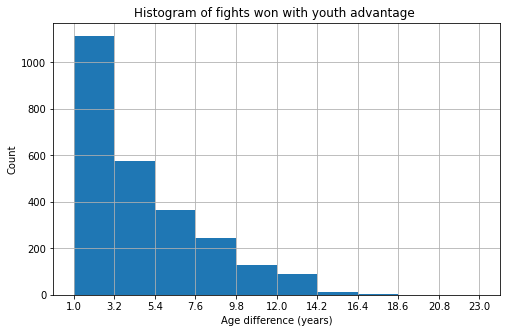

In [20]:
plt.figure(figsize=(8,5))
plt.title('Histogram of fights won with youth advantage ')
plt.xlabel('Age difference (years)')
plt.ylabel('Count')
plt.hist(df_age['age_diff'])
plt.grid()
plt.xticks(bin_edges_age);

#df_age['age_diff'].hist(bins = 20)

- Height

In [21]:
df_height = df[(df['winner_height_adv'] == True)]
height_adv_win = len(df_height.index)
# height_adv_win
print('Percentage of fights with a winner who had a height advantage:', height_adv_win/total_fights)

Percentage of fights with a winner who had a height advantage: 0.41388024883359253


In [22]:
hist_height,bin_edges_height = np.histogram(df_height['height_diff'])
# hist_height
# print("")
# bin_edges_height

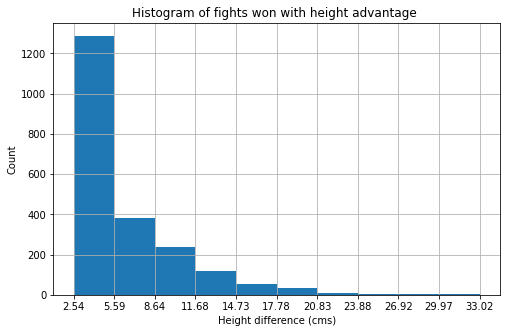

In [23]:
plt.figure(figsize=(8,5))
plt.title('Histogram of fights won with height advantage ')
plt.xlabel('Height difference (cms)')
plt.ylabel('Count')
plt.hist(df_height['height_diff'])
plt.grid()
plt.xticks(bin_edges_height);

#df_height['height_diff'].hist(bins = 20)

- Ape Index<br>
This is a metric we introduce here as it is very interesting. Ape Index is the ratio between fighters arm span and height, usually measured by the difference between a fighters reach and their hight. A positive ape index indicates that a fighter may be able to generate more torque for their punches or be able to grab for takedowns more easily.
<br> See this article: https://howtheyplay.com/individual-sports/10-MMA-Fighters-with-Abnormal-Ape-Index

In [24]:
# ape index is arm span inches/cm minus height
df['R_Ape_Index'] = df['R_Reach_cms'] - df['R_Height_cms']
df['B_Ape_Index'] = df['B_Reach_cms'] - df['B_Height_cms']

In [25]:
# Take a sample to see the ape index 
df.head(1)[['R_Reach_cms','R_Height_cms','R_Ape_Index','B_Reach_cms','B_Height_cms','B_Ape_Index']]

,R_Reach_cms,R_Height_cms,R_Ape_Index,B_Reach_cms,B_Height_cms,B_Ape_Index
0,162.56,162.56,0.0,170.18,167.64,2.54


In [26]:
df['winner_ape_index_adv'] = ((df['Winner'] == 'Red') & (df['R_Ape_Index']>df['B_Ape_Index'])) | ((df['Winner'] == 'Blue') & (df['B_Ape_Index']>df['R_Ape_Index']))

In [27]:
ape_index_adv_win = len(df[(df['winner_ape_index_adv']==True)].index)
ape_index_adv_win

2008

In [28]:
print('Percentage of fights with a winner who had a greater ape index:',ape_index_adv_win/total_fights)

Percentage of fights with a winner who had a greater ape index: 0.39035769828926903


<b>Preparing the data for ML algorithms</b><br>
Many of the parameters regarding the fighters are cumulative and so they do not have much value, and well (as the saying goes) 'styles make fights'. We will stick with some more basic parameters here. We will include _total_rounds_fought since it does give an indicator of experience/mileage a fighter has, which seems useful.<br>
Note: optimally we would want to do seperate modelling for women and men, however we lack data as it is, so we will keep all examples.

In [29]:
param_list = ['R_Height_cms', 
              'B_Height_cms', 
              'R_Reach_cms', 
              'B_Reach_cms', 
              'R_age',
              'B_age', 
              'R_total_rounds_fought',
              'B_total_rounds_fought',
              'Winner'] 

In [30]:
df_input = df[param_list]

- Dealling with NaN values:
<br>Here we see there are some NaN values, how many are there? <br>
If there are few, maybe we can just drop the rows.

In [31]:
is_NaN = df_input.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_input[row_has_NaN]
#rows_with_NaN

In [32]:
# Number of rows with NaN values
print("Number of rows with NaN values", len(rows_with_NaN.index))

Number of rows with NaN values 751


751 seems to be high since we only have 5144 data points in our sample as it is. 751/5144 = 14.6% of our data. <br>
Lets try to replace the NaN values with an average for the column.

In [33]:
# Check the mean values for all columns
df_input.mean()

R_Height_cms             179.274089
B_Height_cms             179.238641
R_Reach_cms              183.664412
B_Reach_cms              183.286128
R_age                     29.442323
B_age                     29.171963
R_total_rounds_fought     12.853421
B_total_rounds_fought      8.920879
dtype: float64

In [34]:
# Check to see outcome of filling df NaN values with the mean
#df_input.fillna(df_input.mean())

In [35]:
# Use the mean of each column to fill its NaN values
df_input_na_filled = df_input.fillna(df_input.mean())

In [36]:
is_NaN = df_input_na_filled.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_input_na_filled[row_has_NaN]
rows_with_NaN
len(rows_with_NaN.index)

,R_Height_cms,B_Height_cms,R_Reach_cms,B_Reach_cms,R_age,B_age,R_total_rounds_fought,B_total_rounds_fought,Winner


0

Good, we now know there are no NaN values.

- Column values:<br>

Previously we calculated the differences of our parameters using the absolute values, however if our differences are negative with respect to the winner then we will be using bad information. For instance if the fight winner is shorter than their opponent this needs to be captured, same goes for age and reach. <br><br>
Therefore we should recalculate the differences with respect to one of the fighters and our model will be used to calculate the probability that one particular fighter is the winner. <br><br>
We will pick Red as the winner, so therefore our output will be y = 1 if Red has won, and we will calculate the differences with respect to Red, ie. R-B for any value.

In [37]:
# we need to recalculate the height_diff, reach_diff, and age_diff fields
# we should also calculate the Ape Indices
# this is because we got the absolute value previously, however we want the values to be with respect to Red now

df_input_na_filled['reach_diff'] = df_input_na_filled['R_Reach_cms'] - df_input_na_filled['B_Reach_cms']
df_input_na_filled['age_diff'] = df_input_na_filled['R_age'] - df_input_na_filled['B_age']
df_input_na_filled['height_diff'] = df_input_na_filled['R_Height_cms'] - df_input_na_filled['B_Height_cms']

df_input_na_filled['R_Ape_Index'] = df_input_na_filled['R_Reach_cms'] - df_input_na_filled['R_Height_cms']
df_input_na_filled['B_Ape_Index'] = df_input_na_filled['B_Reach_cms'] - df_input_na_filled['B_Height_cms']

In [38]:
# if the winner is the Red set the output = 1/True, if Blue output = 0/False
df_input_na_filled['winner_output_red'] = (df['Winner'] == 'Red')

In [39]:
# check the values are set
# df_input_na_filled.head(5)

- Dealing with the output column:<br>
We need to set our output to a 0 or 1

In [40]:
# Convert winner_output to a binary value
df_input_na_filled.loc[df.Winner == 'Red', "winner_output_red"] = 1
df_input_na_filled.loc[df.Winner == 'Blue', "winner_output_red"] = 0

In [41]:
# Now that we are done with the Winner column we can drop it
df_input_na_filled = df_input_na_filled.drop(['Winner'], axis = 1)

# Check the current df
# df_input_na_filled.head(10)

Now check our output column to see if our examples may be skewed towards y=1 or y=0

In [42]:
df_input_na_filled['winner_output_red'].value_counts()

1    3470
0    1674
Name: winner_output_red, dtype: int64

This is bad, we have more than double examples of the red corner winning. We should deal with this by swapping some data where the red corner wins to the data for the blue corner since the corners are arbitrary so we can get a better balance of y=1 to y=0. But in the meantime, we can try using the "stratify=y" option when doing the test/train split.

In [43]:
# find the number of samples needed to swap red with blue 
(3470-1674)/2

898.0

In [44]:
# we are going to use the first 898 examples and exchange the Blue and Red corner labels
df_input_na_filled_first_898 = df_input_na_filled[df_input_na_filled['winner_output_red'] == 1].iloc[0:898]

# check that we got the right output values
df_input_na_filled_first_898['winner_output_red'].value_counts()

1    898
Name: winner_output_red, dtype: int64

In [45]:
# We need to switch the column names for R and B
# df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
df_input_na_filled_first_898 =  df_input_na_filled_first_898.rename(columns={'R_Height_cms':'B_Height_cms', 'B_Height_cms':'R_Height_cms', 'R_Reach_cms':'B_Reach_cms', 'B_Reach_cms':'R_Reach_cms', 'R_age':'B_age', 'B_age':'R_age', 'R_total_rounds_fought':'B_total_rounds_fought', 'B_total_rounds_fought':'R_total_rounds_fought','R_Ape_Index':'B_Ape_Index', 'B_Ape_Index':'R_Ape_Index'})

# The winner was Red but we swapped the data for Red and Blue so now it is the Blue fighter that is the winner so the output changes from 1 to 0
df_input_na_filled_first_898['winner_output_red'] = 0

# Check the ouptut
df_input_na_filled_first_898['winner_output_red'].value_counts()

0    898
Name: winner_output_red, dtype: int64

In [46]:
# remove the rows we have altered from the original dataframe 
df_input_na_filled = df_input_na_filled.drop(df_input_na_filled[df_input_na_filled['winner_output_red'] == 1].iloc[0:898].index, axis=0)

# now the dataframe with the swapped columns using the concatenation function
df_input_na_filled = pd.concat([df_input_na_filled_first_898,df_input_na_filled],ignore_index=True)

# Check that the labels are balanced
df_input_na_filled['winner_output_red'].value_counts()

1    2572
0    2572
Name: winner_output_red, dtype: int64

In [47]:
# Sample here to ensure our data looks good
# df_input_na_filled.iloc[5139]

The examples are balanced now. <br>
Final steps

In [48]:
# Get X and y for our modelling
X = df_input_na_filled.drop(['winner_output_red'], axis = 1)
y = df_input_na_filled['winner_output_red']

In [49]:
# Check X for anything odd
# X

In [50]:
# Check y for anything odd
y

0       0
1       0
2       0
3       0
4       0
       ..
5139    1
5140    1
5141    1
5142    1
5143    1
Name: winner_output_red, Length: 5144, dtype: object

In [51]:
# Change the data type from objec to integer for our output
y=y.astype('int')

In [52]:
# Split into test and train data sets. Use a small split bc we do not have much data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, stratify = y, random_state=1)

<b> Logistic Regression Classifier <b>

In [53]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100000)
lr.fit(X_train, y_train)
#print(lr.intercept_)
#print(lr.coef_)
print()
cv_scores = cross_val_score(lr, X_train, y_train, cv=5,scoring='accuracy')
cv_scores
print()
print("Avg logistic regression accuracy score",cv_scores.mean())
y_pred_lr = lr.predict(X_test)
print("Test accuracy with Logistic Regression Classifier:", accuracy_score(y_test, y_pred_lr))

LogisticRegression(max_iter=100000)

array([0.61239368, 0.61846902, 0.63061968, 0.61846902, 0.61360875])


Avg logistic regression accuracy score 0.618712029161604
Test accuracy with Logistic Regression Classifier: 0.6345966958211856


<b>SGD Classifier<b>

In [54]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)
print()
cv_scores = cross_val_score(sgd_clf, X_train, y_train, cv=5,scoring='accuracy')
cv_scores
print()
print("Avg SGD Classifier accuracy score",cv_scores.mean())
y_pred_sgd = sgd_clf.predict(X_test)
print("Test accuracy with SGD Classifier:", accuracy_score(y_test, y_pred_sgd))

SGDClassifier(random_state=42)

array([0.58930741, 0.5236938 , 0.5054678 , 0.50668287, 0.58566221])


Avg SGD Classifier accuracy score 0.5421628189550425
Test accuracy with SGD Classifier: 0.500485908649174


<b> Decision Tree Classifier </b><br>
We are not sure what depth of tree to use so we will sweep through a set of values to try and find the best option.

In [55]:
from sklearn.tree import DecisionTreeClassifier

train_acc = []
test_acc = []
depth_max = 60

for depth in range(depth_max):
    dt = DecisionTreeClassifier(max_depth = depth+1, random_state=depth)
    model = dt.fit(X_train,y_train)
    depth_train_acc = cross_val_score(model, X_train, y_train, cv=5)
    train_acc.append(np.mean(depth_train_acc))
    depth_test_acc = cross_val_score(model, X_test, y_test, cv=5)
    test_acc.append(np.mean(depth_test_acc))

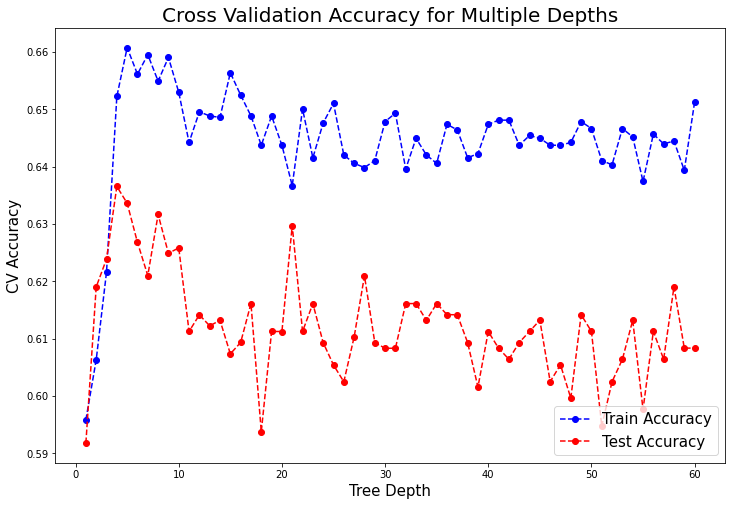

In [56]:
figuresize = plt.figure(figsize=(12,8))
trainAcc = plt.plot(np.arange(depth_max)+1,train_acc, '--bo')   
testAcc = plt.plot(np.arange(depth_max)+1,test_acc, '--ro')   
legend = plt.legend(['Train Accuracy', 'Test Accuracy'], loc ='lower right',  fontsize=15)
title = plt.title('Cross Validation Accuracy for Multiple Depths', fontsize=20)
xlab = plt.xlabel('Tree Depth', fontsize=15)
ylab = plt.ylabel('CV Accuracy', fontsize=15)

Interestingly here, we see that adding depth actually does not help as any as the CV accuracy for the test data seems to be decreaing overall, with the max around depth 4 slightly below 64%.  <br>

In [57]:
# Create new decision Tree with depth 4
# Use all data this time since we are more certain that our accuracy is consistent
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred_dt = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

Accuracy: 0.6656948493683188


Lets plot the Decision tree for insight

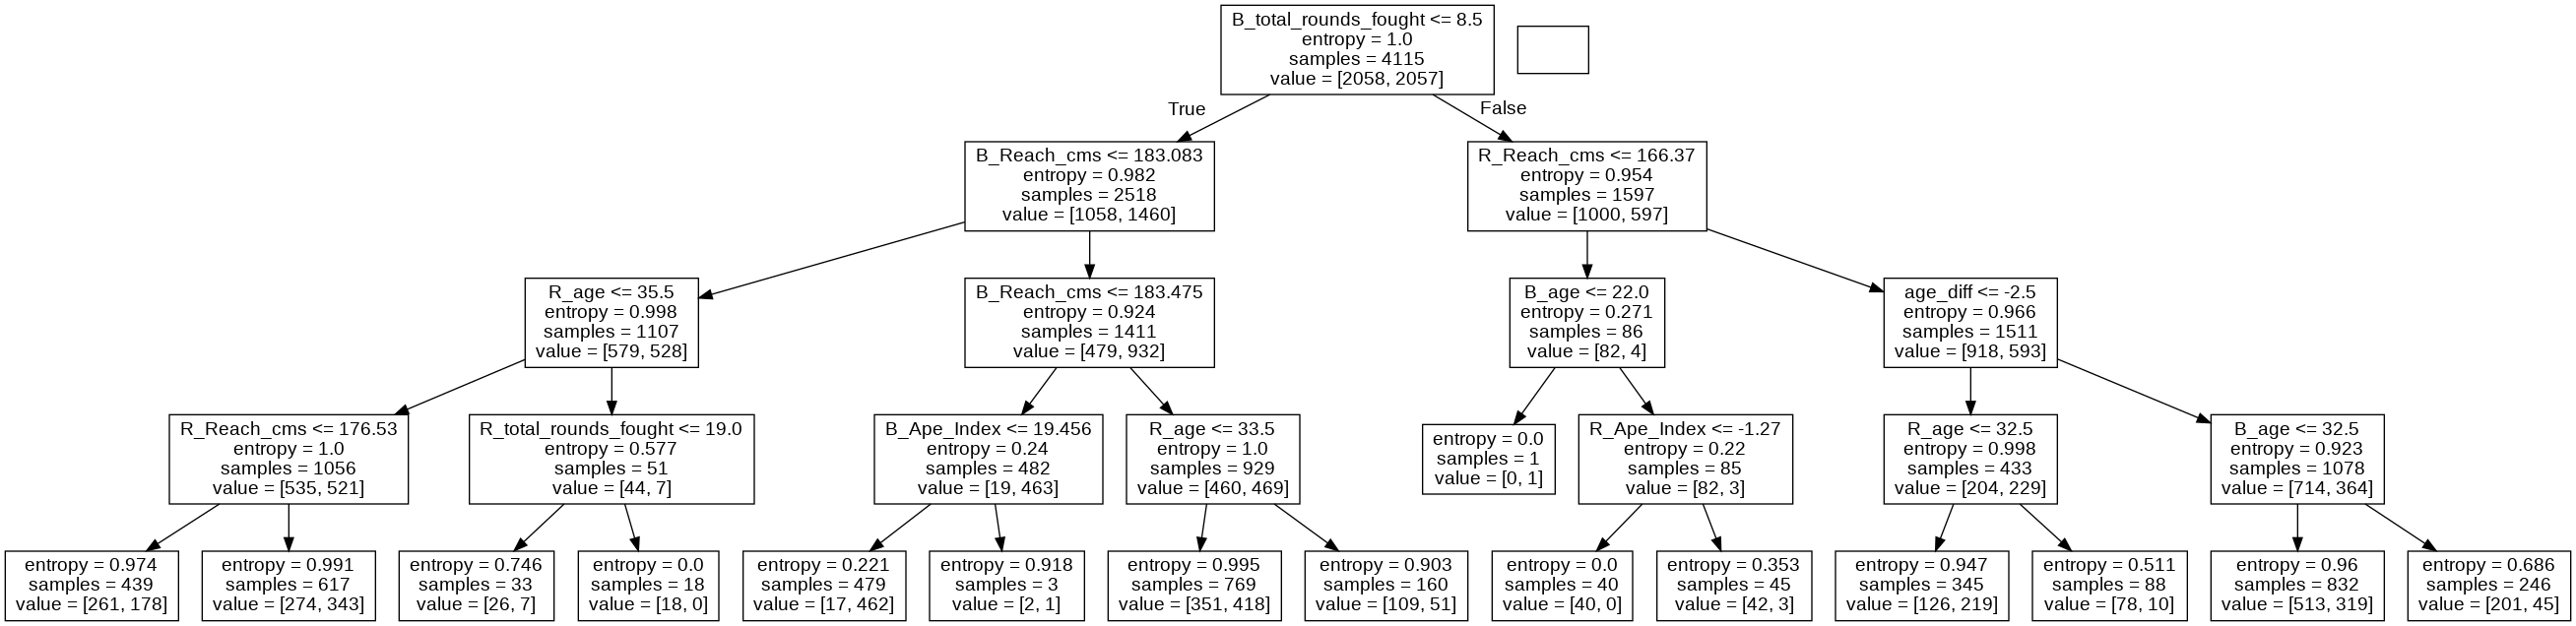

In [58]:
import pydotplus
from sklearn.tree import export_graphviz  
from IPython.display import Image

# Create DOT data
dot_data = export_graphviz(clf, out_file=None, feature_names=X.columns)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

Interesting to note here that the decision tree starts the path depending how much experience the opponent has.
<br>For fun, lets try using an Ensemble method to see if we can get better than a simple decision tree.

<b> Random Forest Classifier <b>

In [59]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
print()
cv_scores = cross_val_score(rnd_clf, X_train, y_train, cv=5,scoring='accuracy')
cv_scores
print()
print("Avg Random Forest Classifier accuracy score",cv_scores.mean())
y_pred_rf = rnd_clf.predict(X_test)
print("Test accuracy with Random Forest Classifier:", accuracy_score(y_test, y_pred_rf))

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, random_state=42)

array([0.69137303, 0.67557716, 0.67071689, 0.67922236, 0.68286756])


Avg Random Forest Classifier accuracy score 0.679951397326853
Test accuracy with Random Forest Classifier: 0.7045675413022352


Suprisingly the test accuracy of the random forest algorithm here is at 70.5% and is somehow higher than the average of the training set, so it seems that something is not right here. The decision tree is not far off at 66.7% which is decent, and fortunately seems to make use of all the parameters it was given, which we can see in the plot. So it is the best model as it is the most interpretable and almost the most accurate.